## Test et analyse du modèle DIST_REL_C_RNN_01

Le modèle DIST_REL_C_RNN_01 affiche des résultats prometteurs durant l'entraînement, mais nous devons nous assurer qu'il est capable de se généraliser à des données qu'il n'a jamais vues. En effet, le risque de sur-ajustement des données d'entraînement est assez grand, sachant que le modèle a appris cent fois sur le jeu d'entraînement, même si nous avons tenté de limiter ce risque en utilisant un dropout (désactivation de certains neurones), et que nous avons limité le nombre de neurones de la couche centrale (58 neurones soit le nombre maximal d'atomes par exemple)

Nous allons donc évaluer le modèle sur le jeu de test, et calculer le RMSE des prédidictions pour en étudier la moyenne et la distribution.

#### Chemin des fichiers

In [228]:

model_loc = "../models/DIST_REL_C_RNN_01/9.2/DIST_REL_C_RNN_01_basic.tfl"

test_set_prepared_input_loc = "../data/DIST_REL_C_RNN/test_set_prepared_input.h5"
test_set_labels_loc = "../data/DIST_REL_C_RNN/test_set_labels.h5"

train_riken_reduced_loc = "../data/train_set_riken_v2_reduced.h5"
test_riken_reduced_loc = "../data/test_set_riken_v2_reduced.h5"

"""
train_riken_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"
test_riken_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"

test_set_prepared_input_loc = "../data/DIST_REL_C_RNN/minimal_prepared_input.h5"
test_set_labels_loc = "../data/DIST_REL_C_RNN/minimal_labels.h5"
"""

'\ntrain_riken_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"\ntest_riken_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"\n\ntest_set_prepared_input_loc = "../data/DIST_REL_C_RNN/minimal_prepared_input.h5"\ntest_set_labels_loc = "../data/DIST_REL_C_RNN/minimal_labels.h5"\n'

## Création du modèle

#### Fonctions de coût et d'évaluation


In [176]:
import tensorflow as tf

def rmse(pred, targets):
    with tf.name_scope("rmse_loss"):
        return tf.sqrt(tf.reduce_mean(tf.squared_difference(pred, targets)), name="rmse")
    
def rmse_valid(pred, targets, inputs):
    with tf.name_scope("rmse_validation"):
        return -rmse(pred, targets)

#### Création du réseau

In [177]:
import tflearn as tfl


def creer_RNN(batch_size, activation="tanh", inner_activation="sigmoid", outlayer_activation="linear",
              depth=2, width=58, dropout_val=0.98, learning_rate=0.001):
    
    # Nombre d'atomes par exemple indéfini [1, 58] -> None
    # 15 valeurs par atome
    network = tfl.input_data(shape=[None, 58, 15], name="input")
    
    for i in range(depth):
        network = tfl.lstm(network, width, return_seq=(i != depth-1), name="hl"+str(i))
        network = tfl.dropout(network, dropout_val)
        
    network = tfl.fully_connected(network, 1, activation='linear')
    
    network = tfl.regression(network, optimizer='adam', loss=rmse, metric=rmse_valid, name="outlayer", 
                             learning_rate=learning_rate)
    
    return network

## Calcul des prédictions

#### Calcul du RMSE sur des vecteurs

In [178]:
import numpy as np

def rmse_test(targets, predictions):
    return np.sqrt(np.square(np.diff([targets, predictions], axis=0)))[0]

#### Calcul de l'erreur sur chaque exemple du jeu de test

In [179]:
import h5py
from tflearn.data_utils import pad_sequences

def calculer_pred(model_loc, test_set_prepared_input_loc, test_set_labels_loc):
    """ Renvoie l'erreur et la prédiction pour chaque exemple du jeu de test """
    
    tf.reset_default_graph()

    
    # Importation du modèle
    network = creer_RNN(5000, learning_rate=0.001, dropout_val=0.98, depth=1, width=58)
    model = tfl.DNN(network)
    model.load(model_loc, weights_only=True)
    
    # Chargement des données
    inputs_h5 = h5py.File(test_set_prepared_input_loc, 'r')
    targets_h5 = h5py.File(test_set_labels_loc, 'r')
    
    inputs = np.array(inputs_h5["inputs"])
    inputs = pad_sequences(inputs, dtype="float32", maxlen=870)
    inputs = inputs.reshape(-1, 58, 15)
    
    targets = np.array(targets_h5["targets"])
    targets = targets.reshape(-1, 1)
    
    predictions = model.predict(inputs)
    
    return rmse_test(targets, predictions).reshape(1, -1)[0], predictions
    
    

In [180]:
rmses, predictions = calculer_pred(model_loc, test_set_prepared_input_loc, test_set_labels_loc)


INFO:tensorflow:Restoring parameters from /home/etudiant/Documents/Cours/TER/Notebooks/models/DIST_REL_C_RNN_01/9.2/DIST_REL_C_RNN_01_basic.tfl


#### Récupération du vecteur cibles (distances)

In [181]:
def extract_targets(test_set_labels_loc):
    targets_h5 = h5py.File(test_set_labels_loc, 'r')
    targets = np.array(targets_h5["targets"])
    targets = targets.reshape(-1, 1)
    return targets


In [182]:
targets = extract_targets(test_set_labels_loc)

## Analyse des résultats

#### Affichage des statistiques sur les erreurs

In [183]:
def print_stats_rmse(rmses):
    print("Erreur moyenne : "+str(np.mean(rmses)))
    print("Erreur médiane : "+str(np.median(rmses)))
    print("Écart-type : "+str(np.std(rmses)))
    print("Erreur min : "+str(min(rmses)))
    print("Erreur max : "+str(max(rmses)))
    

In [184]:
print_stats_rmse(rmses)

Erreur moyenne : 62.63466
Erreur médiane : 63.708374
Écart-type : 21.311611
Erreur min : 0.1862793
Erreur max : 252.01001


#### Représentation graphique de la distribution des rmses selon leur valeur et un pas donné


In [185]:

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['agg.path.chunksize'] = 10000


def plot_distrib_rmses_val(rmses, padding):
    """ Affiche la distribution des rmses selon un pas donné """
    
    # On calcule les bornes de notre index
    debut_index = np.floor(min(rmses))
    fin_index = max(rmses)+padding
    
    # On créé l'index des rmses
    index = np.arange(debut_index, fin_index, padding)
    
    # On créé le compteur de rmses
    rmse_occ = np.zeros_like(index)
        
    # Calcul des rmse
    for rmse in rmses:
        rmse_occ[int((rmse-debut_index)/padding)] += 1
    
    plt.xlabel("Erreur absolue (par tranches de "+str(padding)+" mÅ)")
    plt.ylabel("Occurences sur le jeu de test")
    plt.title("Modèle DIST_REL_C_RNN_01\nDistribution des erreurs selon leur valeur")
    plt.plot(index, rmse_occ)
    plt.savefig("../figures/DIST_REL_C_RNN_01_distrib_rmse_val.png", dpi=800)


    
    

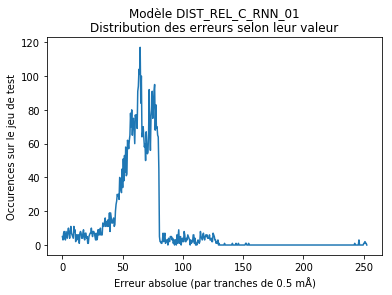

In [186]:
plot_distrib_rmses_val(rmses, 0.5)

![title](../figures/DIST_REL_C_RNN_01_distrib_rmse_val.png)


### Analyse

La distribution des erreurs selon leur valeur montre que le modèle produit des erreurs relativement constantes , la vaste majorité des erreurs étant comprise entre 40 mÅ et 80 mÅ. Il s'agit donc d'un résultat plutôt correct, nous obtenons en effet une précision de l'ordre de $10^{-2}$ Å, même si elle n'est encore à la hauteur de la précision requise en chimie quantique (de l'ordre de $10^{-3}$ Å ou $10^{-4}$ Å).

Les légers pics d'erreurs de 100 mÅ et 250 mÅ pourraient être causés par la difficulté du modèle à prédire les distances entre les doubles et triples liaisons covalentes, qui sont probablement moins représentées dans les données.

#### Distribution des erreurs selon la distance à prédire

In [187]:
def plot_rmse_distrib_dist(rmses, targets):
    
    plt.title("Modèle DIST_REL_C_RNN_01\nDistribution des erreurs selon les distances cibles")
    plt.xlabel("Distance cible (mÅ)")
    plt.ylabel("Erreur absolue (mÅ)")
    plot = plt.plot(targets, rmses, ".")
    
    plt.annotate('', xy=(1380, 240), xytext=(1430, 240),
            arrowprops=dict(facecolor='red', shrink=0.05)
            )
    
    plt.text(1440, 228, "Longueur de liaison\ntypique")
    
    

    plt.annotate('triple', xy=(1200, 0), xytext=(1200, 30),
            arrowprops=dict(facecolor='red', shrink=0.05)
            )
    
    plt.annotate('double', xy=(1340, 0), xytext=(1280, 30),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
    
    plt.annotate('simple', xy=(1540, 0), xytext=(1522, 30),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
    
    plt.annotate('aromatique', xy=(1400, 0), xytext=(1337, 30),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
        
    plt.savefig("../figures/DIST_REL_C_RNN_01_distrib_rmse_dist.png", dpi=200)
    


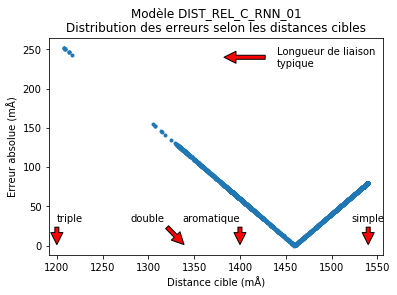

In [188]:
plot_rmse_distrib_dist(rmses, targets)

![title](../figures/DIST_REL_C_RNN_01_distrib_rmse_dist.png)

### Analyse

L'étude de la distribution des erreurs selon les distances attendues montre qu'elle est très linéaire. C'est inquiétant car cela peut indiquer que le modèle ne prédit que les distances moyennes des données qu'il a observé. De plus, il ne semble pas prédire les distances moyennes par classes de liaisons mais uniquement la distance moyenne de l'ensemble des classes pondérées par leur représentation.

Pour vérifier cela, nous allons afficher les prédictions en fonction des distances attendues.




#### Visualisation des prédictions selon les distances attendues

In [189]:
def plot_sorted_targets_pred(targets, preds):
        
    plt.title("Modèle DIST_REL_C_RNN_01\n Prédictions en fonction des distances cibles")
    plt.xlabel("Distance cible (mÅ)")
    plt.ylabel("Distance prédite (mÅ)")
    
    plt.plot(targets, preds, ".")
    
    plt.savefig("../figures/DIST_REL_C_RNN_01_preds_fonction_cibles.png", dpi=200)



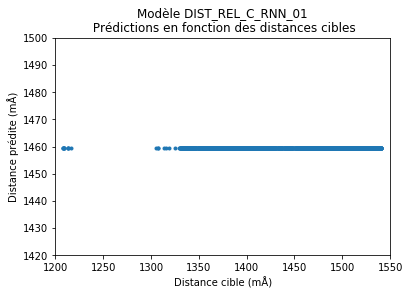

In [190]:
plot_sorted_targets_pred(targets, predictions)

![title](../figures/DIST_REL_C_RNN_01_preds_fonction_cibles.png)

### Analyse

On voit ici très nettement que le modèle a appris à ne prédire qu'une unique valeur, peu importe les données d'entrée. Cette valeur est très probablement la moyenne des distances inter-carbone qu'il a observé dans le jeu d'entraînement.

Il s'agit donc d'un modèle qui effectue de la mécanique moléculaire (travail sur les distances moyennes), mais qui est moins efficace que les outils comme open-babel car il ne prend pas en compte les types de liaisons pour effectuer ses prédictions.

Nous allons donc devoir élaborer un modèle possédant une topologie plus complexe, ou des entrées lui apportant plus d'informations, mais nous allons dans un premier temps étudier la distribution des distances inter-carbones dans le jeu de données pour mieux comprendre les données sur lequel le modèle a appris.



## Étude du jeu de données d'apprentissage

Nous allons étudier la distribution des distances inter-carbone dans le jeu de données d'apprentissage. Nous n'allons pas nous limiter à l'étude des liaisons covalentes qui sont les seules que nous avons introduites dans les jeux d'entraînement et de test, mais nous allons étudier toutes les distances inter-carbone.

#### Calcul des distances

In [220]:
import numpy as np

def calcul_distance(pt1, pt2):
    """ Renvoie la distance entre deux points représentés par leurs coordonnées (x, y, z) dans deux tableaux
    de forme (1, 3)"""
    return np.sqrt(np.sum(np.square(np.diff(np.array([pt1, pt2]), axis=0))))

#### Calcul du vecteur de distances inter-carbones pour une molécule

In [221]:
def vect_dist_mol(coords_mol, anums_mol, ):
    
    coords_mol = coords_mol.reshape(-1, 3)
    taille_mol = len(coords_mol)
    dists = []
    
    # On itère sur tous les atomes de la molécule
    for i in range(taille_mol):
        
        # On ne s'intéresse qu'aux atomes de carbone
        if anums_mol[i] == 6.:
            
            # On parcourt tous les atomes suivants
            for j in range(i+1, taille_mol):
                                
                # On ne s'intéresse qu'aux couples d'atomes de carbone
                if anums_mol[j] == 6:
                    
                    dists.append(calcul_distance(coords_mol[i], coords_mol[j]))
                    
        else:
            # Les carbones étant les premiers atomes de la molécule dans les données, on arrête la boucle
            # pour gagner du temps d'exécution
            break
                
    return dists
            

#### Calcul du vecteur de distances inter-carbones pour toutes les molécules du jeu

In [222]:
import h5py
import time

def vect_dist(original_dataset_loc, nb_mol):
        
    # On charge les données du jeu original en mémoire
    original_dataset_h5 = h5py.File(original_dataset_loc, "r")
    input_coords = np.array(original_dataset_h5["riken_coords"][:nb_mol])
    input_nums = np.array(original_dataset_h5["anums"][:nb_mol])
    
    dists = []
        
    try:
        
        # On parcourt toutes les molécules du jeu original
        for ori_idx in range(len(input_coords)):
                
            # On ne s'intéresse pas aux molécules contenenant des atomes plus lourds que le fluor (comme
            # lors de la génération des entrées du RN)
            
            if max(input_nums[ori_idx])<10:
                
                # On enregistre les distances de la molécule courante
                dists.extend(vect_dist_mol(input_coords[ori_idx], input_nums[ori_idx]))
            
        return np.array(dists)
                
    finally:

        original_dataset_h5.close()


### Analyse de la distribution des distances carbone-carbone sur le jeu d'entraînement

On ne s'intéresse qu'aux distances carbone-carbone des 400000 premières molécules du jeu d'entraînement réduit (il s'agit du même sous-ensemble du jeu réduit que celui utilisé pour créer le jeu d'entraînement pour le modèle DIST_REL_C_RNN_01)

In [223]:
dists_c_c_train = vect_dist(train_riken_reduced_loc, 400000)

In [224]:
print(dists_c_c_train.shape)

(4169764,)


#### Statistiques générales

In [225]:
def print_stats(arr):
    print("Moyenne : "+str(np.mean(arr)))
    print("Médiane : "+str(np.median(arr)))
    print("Écart-type : "+str(np.std(arr)))
    print("Valeur min : "+str(min(arr)))
    print("Valeur max : "+str(max(arr)))
    
print_stats(dists_c_c_train)

Moyenne : 3.9581926
Médiane : 3.6845646
Écart-type : 2.008079
Valeur min : 1.1985348
Valeur max : 19.119377


#### Sortie

```
Erreur moyenne : 62.555367
Erreur médiane : 63.821777
Écart-type : 21.361195
Erreur min : 0.0
Erreur max : 287.61035
```

#### Distribution des différentes distances inter-carbones

In [226]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['agg.path.chunksize'] = 10000

def plot_distrib_dist_c(dists, padding, output_file):
    """ Affiche la distribution des rmses selon un pas donné """
    
    # On calcule les bornes de notre index
    debut_index = np.floor(min(dists))
    fin_index = max(dists)+padding
    
    # On créé l'index
    index = np.arange(debut_index, fin_index, padding)
    
    # On créé le compteur d'occurences
    dists_occ = np.zeros_like(index)
        
    # Calcul des occurences
    for dist in dists:
        dists_occ[int((dist-debut_index)/padding)] += 1
        
    axes = plt.gca()
    axes.set_xlim([1, 2.77])
    
    plt.xlabel("Distance inter-carbone (par tranches de "+str(padding)+" Å)")
    plt.ylabel("Nombre d'occurences dans les données")
    plt.title("Modèle DIST_REL_C_RNN_01\nDistribution des distances inter-carbones\ndans les données d'entraînement")
    plt.plot(index, dists_occ)
    
    plt.annotate('', xy=(1.17, 250000), xytext=(1.58, 250000),
            arrowprops={'arrowstyle': '|-|'})
    
    plt.text(1.6, 255000,'Liaisons covalentes')
    
    
    plt.annotate('', xy=(2.3, 150000), xytext=(2.7, 150000),
            arrowprops={'arrowstyle': '|-|'})
    
    plt.text(1.9, 140000,'Interactions de \nVan Der Waals')
    
    plt.annotate('simples', xy=(1.58, 400000), xytext=(1.75, 405000),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
    
    plt.annotate('doubles', xy=(1.38, 350000), xytext=(1.02, 355000),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
    
    plt.annotate('triples', xy=(1.2, 15000), xytext=(1.02, 95000),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
    
    
    plt.savefig(output_file, dpi=200)


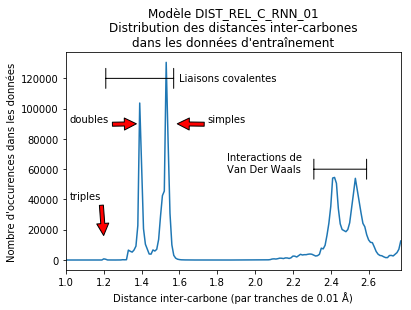

In [227]:
plot_distrib_dist_c(dists_c_c_train, 0.01, "../figures/DIST_REL_C_RNN_01_distrib_dists_train_C.png")

![title](../figures/DIST_REL_C_RNN_01_distrib_dists_train_C.png)


### Analyse de la distribution des distances carbone-carbone sur le jeu de test

On effectue les mêmes affichages sur le jeu de test, pour tester l'homogénéité du jeu de données



In [ ]:
dists_c_c_test = vect_dist(test_riken_reduced_loc, 80000)

In [ ]:
print_stats(dists_c_c_test)

In [ ]:
plot_distrib_dist_c(dists_c_c_test, 0.01, "../figures/DIST_REL_C_RNN_01_distrib_dists_test_C.png")

![title](../figures/DIST_REL_C_RNN_01_distrib_dists_test_C.png)
